In [2]:
import argparse
import datetime
import json
import numpy as np
import os
import time
from pathlib import Path

import torch.nn.functional as F
import wfdb
import re
from os.path import exists


import torch
import torch.backends.cudnn as cudnn
# from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import timm

# assert timm.__version__ == "0.3.2"  # version check
import timm.optim.optim_factory as optim_factory

import utils.misc as misc
from utils.misc import NativeScalerWithGradNormCount as NativeScaler

import models_mae

from engine_pretrain import train_one_epoch

In [3]:
import glob
import wfdb
from wfdb import processing
import re
import numpy as np
import torch
dataset = []
files = 0
for n in range(43,44):
    for j in range(0, 10):
        for filepath in glob.iglob( '/Users/parthagrawal02/Desktop/Carelog/ECG_CNN' + '/physionet/WFDBRecords/' + f"{n:02}" +  '/' + f"{n:02}" + str(j) +  '/*.hea'):
            try:
                ecg_record = wfdb.rdsamp(filepath[:-4])
            except Exception:
                continue
            # annots = wfdb.Annotation(filepath[:-4], 'hea')
            # print(ecg_record[0].transpose(1,0).shape)
            numbers = re.findall(r'\d+', ecg_record[1]['comments'][2])
            output_array = list(map(int, numbers))
            lx = []
            for chan in range(ecg_record[0].shape[1]):
                resampled_x, _ = wfdb.processing.resample_sig(ecg_record[0][:, chan], 500, 100)
                lx.append(resampled_x)
            dataset.append(lx)

dataset = np.array(dataset)
dataset = dataset.astype(np.double, copy=False)
X = torch.from_numpy(dataset[:, :, :])
X = X[:, None, :, :]

In [4]:
# Reconstruction from the 220th epoch checkpoints
from models_mae import mae_vit_1dcnn
test_model = mae_vit_1dcnn()
test_model = test_model.double()
test_model.eval()
# Load model checkpoints
checkpoint_loc = 'checkpoint-236.pth'
checkpoint = torch.load(checkpoint_loc, map_location='cpu')
test_model.load_state_dict(checkpoint['model'], strict = True)

<All keys matched successfully>

In [5]:
def unpatchify(x):
    """
    x: (N, L, patch_size_height*patch_size_width*1)
    imgs: (N, 1, H, W) - 12 channel ECG - H = No. of channels, W = Length of ECG signal (1000 in this case)
    """
    ph = 1
    pw = 50

    # h = w = int(x.shape[1]**.5)
    # assert h * w == x.shape[1]
    h = 12
    w = x.shape[1]//12

    x = x.reshape(shape=(h, w, ph, pw, 1))
    x = torch.einsum('hwpqc->chpwq', x)
    imgs = x.reshape(shape=(1, h * ph, w * pw))
    return imgs


In [21]:
i = 900
input = X[i:i+1]
loss, pred, mask  = test_model(X[i:i+1])
loss

tensor(0.5033, dtype=torch.float64, grad_fn=<DivBackward0>)

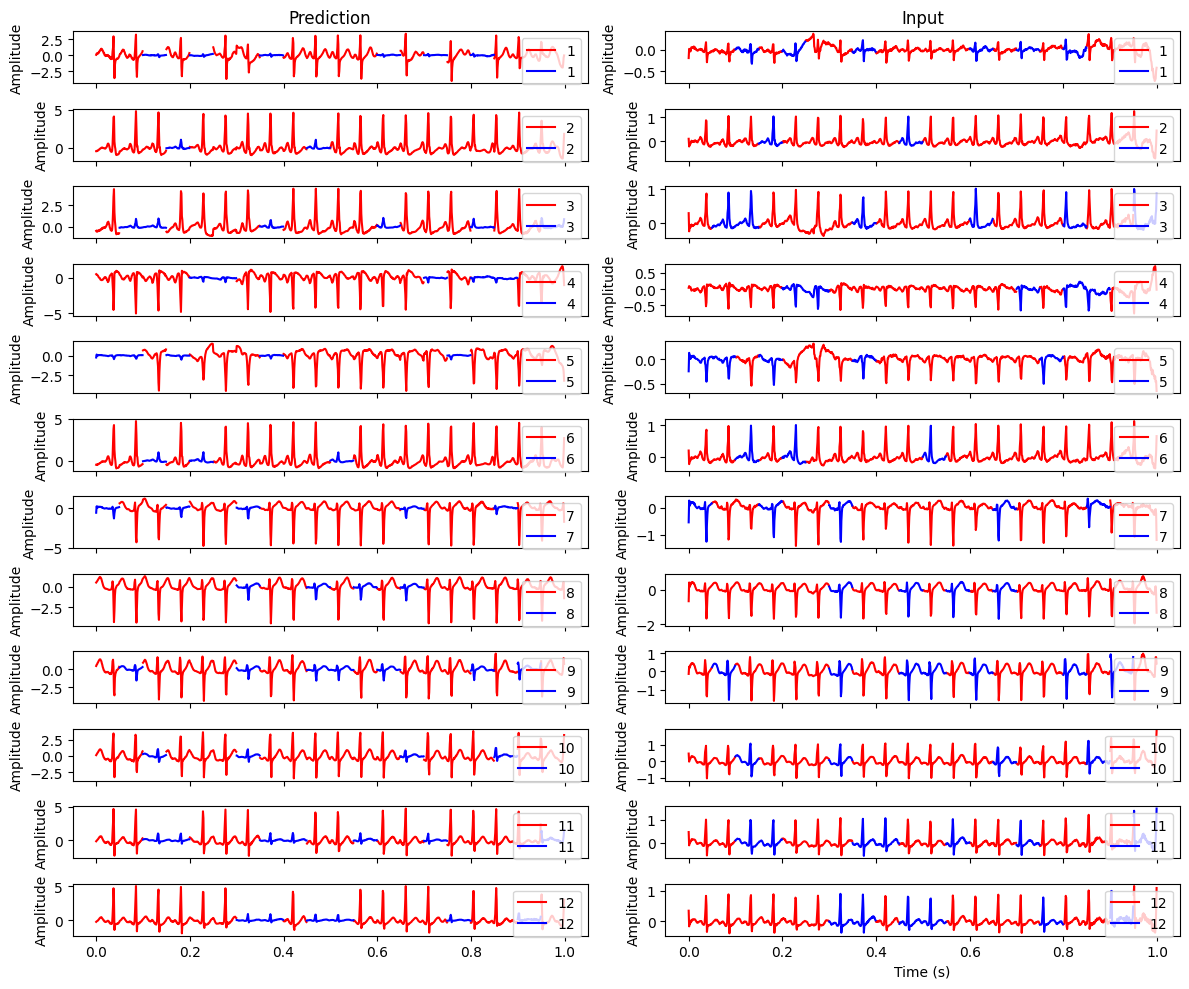

In [13]:
import matplotlib.pyplot as plt

ecg_data = unpatchify(pred)
ecg_data = ecg_data.detach().numpy()
mask_data = np.repeat(mask[0, :], 50).reshape(shape = (1, 12, 1000))

time_axis = np.arange(0, 1000) / 1000.0

# Create subplots for the two sets of ECG signals side by side
fig, axes = plt.subplots(12, 2, figsize=(12, 10), sharex=True)

# Plot each channel for the first set of ECG signals
for i in range(12):  # INPUT
    channel_data = input[0, 0, i, :]
    mask_channel = mask_data[0, i, :]
    unmasked_data = np.where(mask_channel == 0, channel_data, np.nan)
    masked_data = np.where(mask_channel == 1, channel_data, np.nan)

    axes[i, 1].plot(time_axis, masked_data, label = str(i+1), color = 'red')
    axes[i, 1].plot(time_axis, unmasked_data, label = str(i+1), color = 'blue')
    axes[i, 1].set_ylabel('Amplitude')
    axes[i, 1].legend(loc='upper right')

for i in range(12): # RECONSTRUCTION
    channel_data = ecg_data[0, i, :]
    input_data = input[0, 0, i, :]
    mask_channel = mask_data[0, i, :]
    unmasked_data = np.where(mask_channel == 0, input_data, np.nan)
    masked_data = np.where(mask_channel == 1, channel_data, np.nan)

    axes[i, 0].plot(time_axis, masked_data, label = str(i+1), color = 'red')
    axes[i, 0].plot(time_axis, unmasked_data, label = str(i+1), color = 'blue')

    axes[i, 0].set_ylabel('Amplitude')
    axes[i, 0].legend(loc='upper right')

axes[-1, 1].set_xlabel('Time (s)')
axes[0, 0].set_title('Prediction')
axes[0, 1].set_title('Input')

plt.tight_layout()
plt.show()